In [6]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from tqdm import tqdm
import time

In [7]:
# creating connectivity cache and other constant variables
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
voxel_size = 25  # µm
min_injection_volume = 0.001  # mm³
corpus_callosum_ids = [776, 1108, 986, 956]
isocortex_id = 315

In [8]:
# loading and filtering experiments
print("Loading isocortex non-cre injection experiments...")
experiment_data = mcc.get_experiments(cre=False, injection_structure_ids=[isocortex_id])
print(f"Total isocortex experiments: {len(experiment_data)}")

excluded_acronyms = {}
filtered_experiments = []

for exp in experiment_data:
    try:
        struct = structure_tree.get_structures_by_id([exp['structure_id']])[0]
        acronym = struct['acronym']
        inj_vol = exp.get('injection_volume', 0)
        if acronym not in excluded_acronyms and inj_vol >= min_injection_volume:
            filtered_experiments.append(exp)
    except Exception as e:
        print(f"Skipping experiment {exp.get('id')} due to error: {e}")

experiment_ids = [exp['id'] for exp in filtered_experiments]
print(f"Using {len(experiment_ids)} experiments after acronym and volume filtering")

Loading isocortex non-cre injection experiments...
Total isocortex experiments: 129
Using 129 experiments after acronym and volume filtering


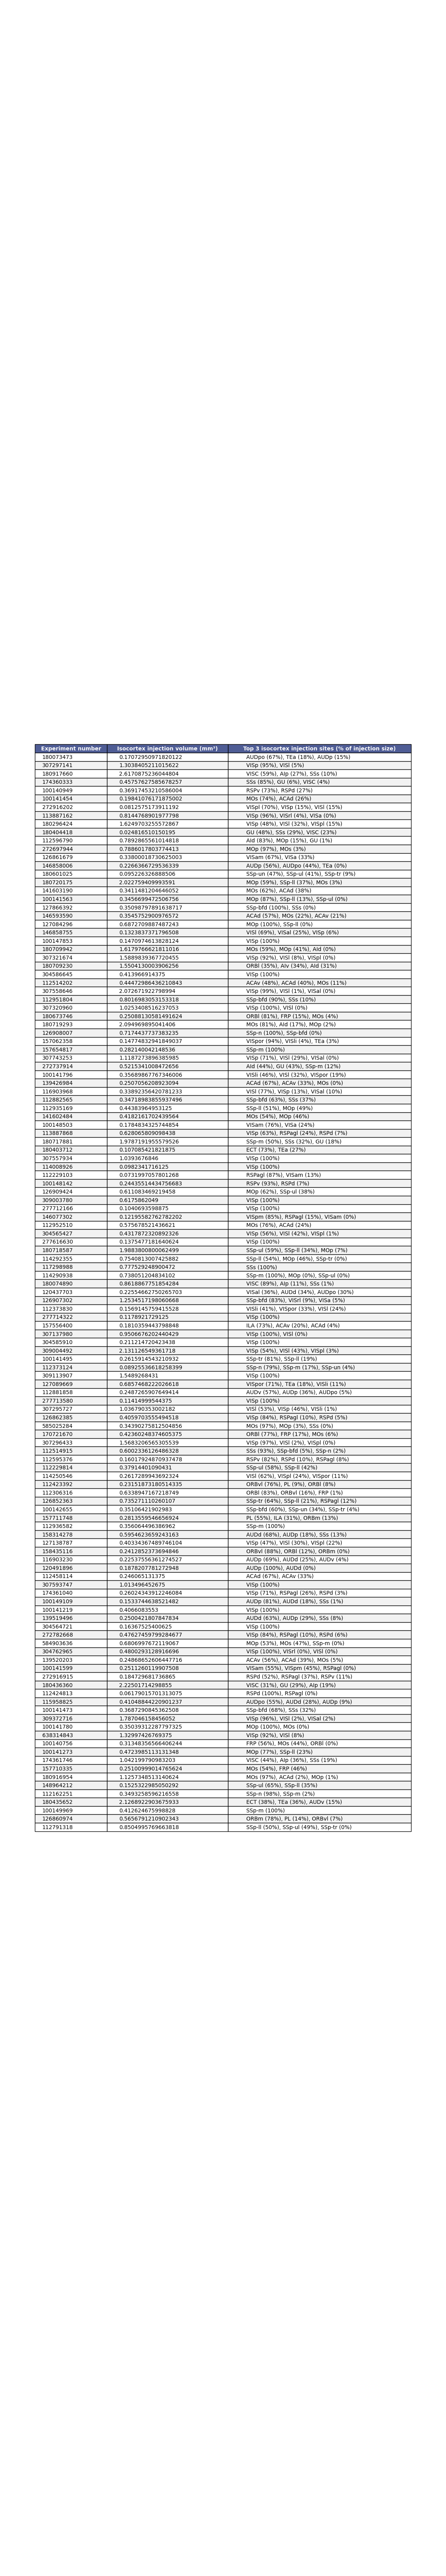

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Get Isocortex ID and all leaf structures within it ---
isocortex_id = structure_tree.get_structures_by_name(['Isocortex'])[0]['id']
summary_structures = structure_tree.get_structures_by_set_id([167587189])  # Summary leaf set
isocortex_leaf_ids = [s['id'] for s in summary_structures 
                      if isocortex_id in s['structure_id_path']]

# --- Use all filtered experiments ---
sample_experiments = filtered_experiments
sample_ids = [exp['id'] for exp in sample_experiments]

# --- Download unionizes for all experiments ---
all_unionizes = mcc.get_structure_unionizes(experiment_ids=sample_ids,
                                            is_injection=True)

# --- Map structure_id -> acronym ---
all_struct_ids = all_unionizes['structure_id'].unique().tolist()
structures = structure_tree.get_structures_by_id(all_struct_ids)
id_to_acronym = {s['id']: s['acronym'] for s in structures}
all_unionizes['acronym'] = all_unionizes['structure_id'].map(id_to_acronym)

# --- Filter to Isocortex leaf nodes only ---
all_unionizes_iso = all_unionizes[all_unionizes['structure_id'].isin(isocortex_leaf_ids)]

# --- Build table rows for ALL experiments ---
rows = []
for exp in sample_experiments:
    exp_id = exp['id']
    inj_vol = exp.get('injection_volume', 0)

    # Unionizes for this experiment (Isocortex leaf only)
    u = all_unionizes_iso[all_unionizes_iso['experiment_id'] == exp_id]
    total_vol = u['volume'].sum()

    if total_vol > 0:
        grouped = (u.groupby('acronym')['volume']
                     .sum()
                     .sort_values(ascending=False)
                     .head(3))
        sites = [f"{acr} ({(vol / total_vol * 100):.0f}%)" for acr, vol in grouped.items()]
        sites_text = ", ".join(sites)
    else:
        sites_text = "No isocortex injection"

    rows.append([exp_id, total_vol, sites_text])

# --- Build DataFrame ---
df = pd.DataFrame(rows, columns=[
    "Experiment number",
    "Isocortex injection volume (mm³)",
    "Top 3 isocortex injection sites (% of injection size)"
])

# --- Plot table ---
fig, ax = plt.subplots(figsize=(12, 2 + len(df) * 0.5))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='left', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(list(range(len(df.columns))))

# Header style
for col in range(len(df.columns)):
    header_cell = table[(0, col)]
    header_cell.set_facecolor('#4F5D95')
    header_cell.set_text_props(color='white', weight='bold')

# Alternating row colors
for row in range(1, len(df) + 1):
    bg_color = '#FFFFFF' if row % 2 else '#F2F2F2'
    for col in range(len(df.columns)):
        cell = table[(row, col)]
        cell.set_facecolor(bg_color)
        cell.set_text_props(color='black')

# Borders
for key, cell in table.get_celld().items():
    cell.set_edgecolor("black")

plt.tight_layout()
plt.show()
